In [1]:
import pandas as pd 
import numpy as np
import statsmodels.api as sms
import matplotlib.pyplot as plt
from scipy import stats
import tqdm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import TimeSeriesSplit
from pylab import rcParams
from sklearn.metrics import mean_absolute_error as mae
from tqdm import tqdm_notebook
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 100)
data = pd.read_csv('/kaggle/input/grocery-sales-forecast/train.csv', parse_dates=['date'], index_col='date')

In [3]:
data

,warehouse_id,product_id,quantity,id
date,,,,
2020-12-02,0,71165,1,0
2020-12-03,0,71165,3,1
2020-12-07,0,71165,2,2
2020-12-08,0,71165,2,3
2020-12-09,0,71165,3,4
...,...,...,...,...
2021-04-06,1,98255,3,83132
2021-04-07,1,98255,1,83133
2021-04-07,1,98615,1,83146


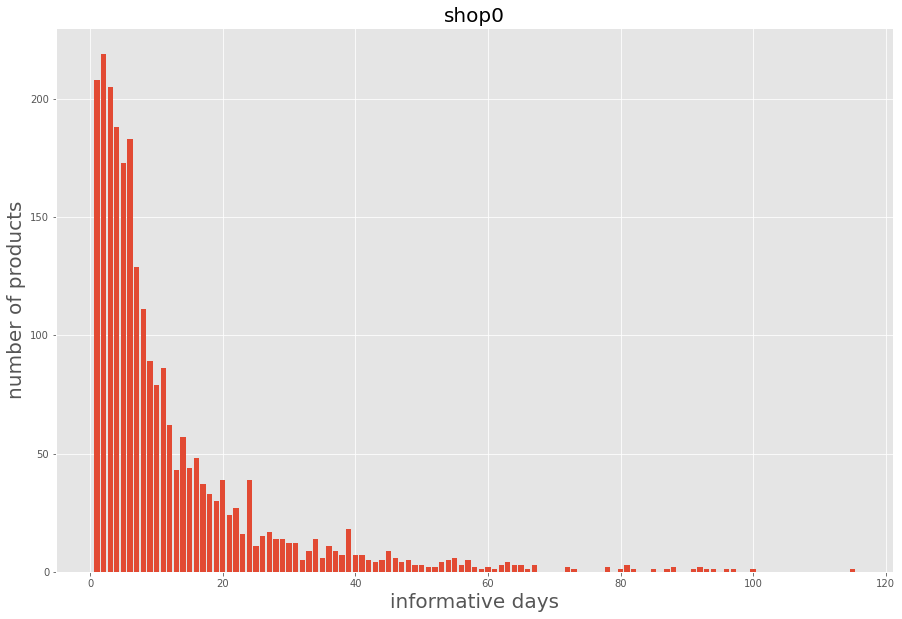

In [4]:
df0 = data[data.warehouse_id == 0]
df0['appear'] = np.ones(df0.shape[0], dtype = 'int')
infoset0 = df0.groupby('product_id')['appear'].sum().to_frame()
infoset0['extra'] = np.ones(infoset0.shape[0], dtype = 'int')
res0 = infoset0.groupby('appear')['extra'].sum()
plt.figure(figsize=(15,10))
plt.bar(res0.index, res0)
plt.title('shop0', fontsize = 20)
plt.xlabel('informative days', fontsize = 20)
plt.ylabel('number of products', fontsize = 20)
plt.show()

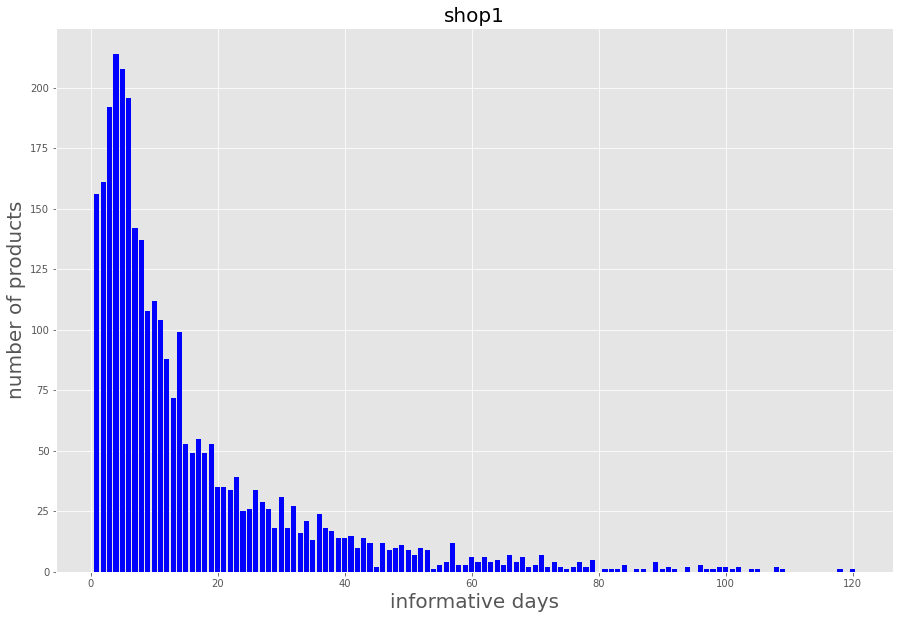

In [5]:
df1 = data[data.warehouse_id == 1]
df1['appear'] = np.ones(df1.shape[0], dtype = 'int')
infoset1 = df1.groupby('product_id')['appear'].sum().to_frame()
infoset1['extra'] = np.ones(infoset1.shape[0], dtype = 'int')
res1 = infoset1.groupby('appear')['extra'].sum()
plt.figure(figsize=(15,10))
plt.bar(res1.index, res1, color = 'blue')
plt.title('shop1', fontsize = 20)
plt.xlabel('informative days', fontsize = 20)
plt.ylabel('number of products', fontsize = 20)
plt.show()

Видно, что для большого количества товаров есть информация только за 1 - 3 дня. Логично предположить, что в остальные дни они не продавались

In [6]:
test_data = pd.read_csv('/kaggle/input/grocery-sales-forecast/test.csv', parse_dates=['date'], index_col='date')

In [7]:
test_data

,product_id,warehouse_id,id
date,,,
2021-04-09,71165,0,0
2021-04-09,71165,1,1
2021-04-09,71170,0,2
2021-04-09,71170,1,3
2021-04-09,71185,0,4
...,...,...,...
2021-04-15,98615,1,46027
2021-04-15,98620,0,46028
2021-04-15,98620,1,46029


In [8]:
product_ids = test_data['product_id'].unique()

In [9]:
temp_data = data.copy()
temp_data = temp_data.sort_values(by=['date'])
dates = temp_data.index.unique()

In [10]:
results = np.array([])
for i in range(0,2):
    for j in tqdm_notebook(product_ids):
        train = data[(data['product_id'] == j) & (data['warehouse_id'] == i)]
        test = test_data[(test_data['product_id'] == j) & (test_data['warehouse_id'] == i)]
        if train.shape[0] < 20:
            forecast = pd.Series(np.zeros(test.shape[0], dtype = 'int'))
            forecast.index = test.index
            results = np.hstack((results, forecast.values))
        else:
            for date in dates:
                if date not in train.index:
                    train.loc[date] = [0, 0, 0, 0]
            fit1 = ExponentialSmoothing(np.asarray(train.quantity) ,seasonal_periods = 31 ,trend=None, seasonal='add').fit()
            forecast = pd.Series(fit1.forecast(test.shape[0]))
            forecast.index = test.index
            results = np.hstack((results, forecast.values))

  0%|          | 0/3288 [00:00<?, ?it/s]

  0%|          | 0/3288 [00:00<?, ?it/s]

In [11]:
answer = test_data.copy()
answer.sort_values(by=['product_id','warehouse_id', 'date'])
results_normal = np.around(results).astype(int)
answer['quantity'] = results_normal
answer.sort_values(by='id')
with open("final_results.csv", "w") as f:
    f.write(answer.to_csv(columns=("id", "quantity"), index=False))